# Parameter scan runs for 1D kinematic driver model

Author: Jatan Buch (v1, 240501) || (v2, 241022)

In [1]:
from case_files.settings_time import Settings 
from case_files.simulation_sd_update import Simulation
import numpy as np
import xarray
from tqdm import tqdm

import itertools
import pandas as pd

from PySDM import Formulae
from PySDM.initialisation.spectra import Lognormal
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d

from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from utils.plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

sav_file_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/sav_files/parameter_scan_1D/"
sav_plt_path= "/Users/hyfives-lamont/Desktop/cloud_seeding/plots/parameter_scan_1D/"

## Case setup

In [2]:
def KiD_run(param, bkg_size= 1E-1, seed_size= 1, z_part_seed= (0., 0.25), t_part_seed= 60, rho_times_w= 2, rindx= 0, n_runs= 10, rseed= 42):

        norm_bkg, norm_seed = param

        kappa_bkg= 0.3
        kappa_seed= 0.85
        
        common_params = {
        "t_max": 60 * si.minutes,
        "n_sd_per_mode": (32, 32), 
        "aerosol_modes_by_kappa": {
                kappa_bkg: Lognormal(
                                norm_factor= norm_bkg / si.cm ** 3,
                                m_mode= bkg_size * si.um,
                                s_geom=1.4
                        ),
                kappa_seed: Lognormal(
                                norm_factor= 0.1 / si.cm ** 3,
                                m_mode= seed_size * si.um,
                                s_geom= 1.2
                        )
                },
        "dt": 5 * si.s,
        "dz": 50 * si.m,
        "p0": 990 * si.hPa,
        "z_part": ((0., 1.), z_part_seed),
        "r_seed": seed_size * si.um,
        "kappa_seed": 0.85,
        "int_inj_rate": norm_seed / si.cm ** 3,
        "seed_z_step": [z_part_seed],
        "seed_t_step": [t_part_seed],
        }

        output = {}
        settings = {}
        simulation = {}
        rain_xarr = {}

        np.random.seed(rseed)

        for r_id in range(n_runs):
                key = f"param_list_{rindx}_run={r_id}"
                settings[key] = Settings(
                        **common_params,
                        formulae= Formulae(seed= np.random.randint(1000)),
                        rho_times_w_1=rho_times_w * si.kg/si.m**3 * si.m/si.s,
                        precip= True
                        )
                simulation[key] = Simulation(settings[key])
                output[key] = simulation[key].stepwise_sd_update(seeding_type= 'aggregate').products
                
                rain_xarr[key]= xarray.DataArray(data= output[key]['rain water mixing ratio'],
                                dims=["z", "t"],
                                coords=dict(
                                        t=(["t"], output[key]['t'],),
                                        z=(["z"], output[key]['z'],),)
                                )

        surface_rain= xarray.concat([rain_xarr[f"param_list_{rindx}" + "_run=" + str(i)] for i in range(n_runs)], dim="run")
        surface_rain= surface_rain.assign_coords(run=range(n_runs))

        return surface_rain

In [3]:
norm_bkg= np.array([20]) #np.logspace(1, np.log10(500), 2)
norm_seed= np.array([500]) #np.logspace(0, np.log10(500), 2)
#z_part_seed= ((0., 0.25), (0.25, 0.50), (0.5, 0.75) , (0.75, 1.))

param_list= list(itertools.product(norm_bkg, norm_seed))
kid_run_df= pd.DataFrame(param_list, columns= ['norm_bkg', 'norm_seed'])

In [4]:
bkg_size= 1E-1 # in si.um
seed_size= 5 # in si.um
z_part_seed= (0., 0.25)
t_part_seed= 120
rho_times_w= 2 # in si.kg/si.m**3 * si.m/si.s

mean_surf_prec_arr= []
sig_surf_prec_arr= []

for i in tqdm(range(len(param_list))): 
    try:
        surface_rain= KiD_run(param= param_list[i], bkg_size= bkg_size, seed_size= seed_size, z_part_seed= z_part_seed, t_part_seed= t_part_seed,
                                                                rho_times_w= rho_times_w, rindx=i, n_runs= 20, rseed= 67)
        surface_rain.to_netcdf(sav_file_path + f'KiD_run_{i+1}.nc') # saving the netcdf file
        
        mean_surf_prec_arr.append(surface_rain.sel(z= 25).sum(dim= 't').mean(dim= 'run').values.item())
        sig_surf_prec_arr.append(surface_rain.sel(z= 25).sum(dim= 't').std(dim= 'run').values)
    except:
        mean_surf_prec_arr.append(np.nan)
        sig_surf_prec_arr.append(np.nan)

# add columns to kid_run_df for bkg_size, seed_size, z_part_seed, rho_times_w which are the same for all runs
kid_run_df['bkg_size']= bkg_size 
kid_run_df['seed_size']= seed_size 
kid_run_df['z_part_seed']= [(0., 0.25)] * len(param_list)
kid_run_df['rho_times_w']= 2 

kid_run_df['surf_precip_mean']= np.array(mean_surf_prec_arr)
kid_run_df['surf_precip_std']= np.array(sig_surf_prec_arr)
kid_run_df.to_hdf(sav_file_path + 'KiD_run_rhow=2.0_rbkg_0.1_rseed_5_zseed_0.25_tseed_120_summary.h5', key='df')

  0%|          | 0/1 [00:00<?, ?it/s]/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
/Users/hyfives-lamont/Desktop/cloud_seeding/PySDM/PySDM/backends/numba.py:46: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.war

In [5]:
kid_run_df

,norm_bkg,norm_seed,bkg_size,seed_size,z_part_seed,rho_times_w,surf_precip_mean,surf_precip_std
0,20,500,0.1,5,"(0.0, 0.25)",2,NaN,NaN


<xarray.DataArray ()>
array(297.05920178)
Coordinates:
    z        float64 25.0

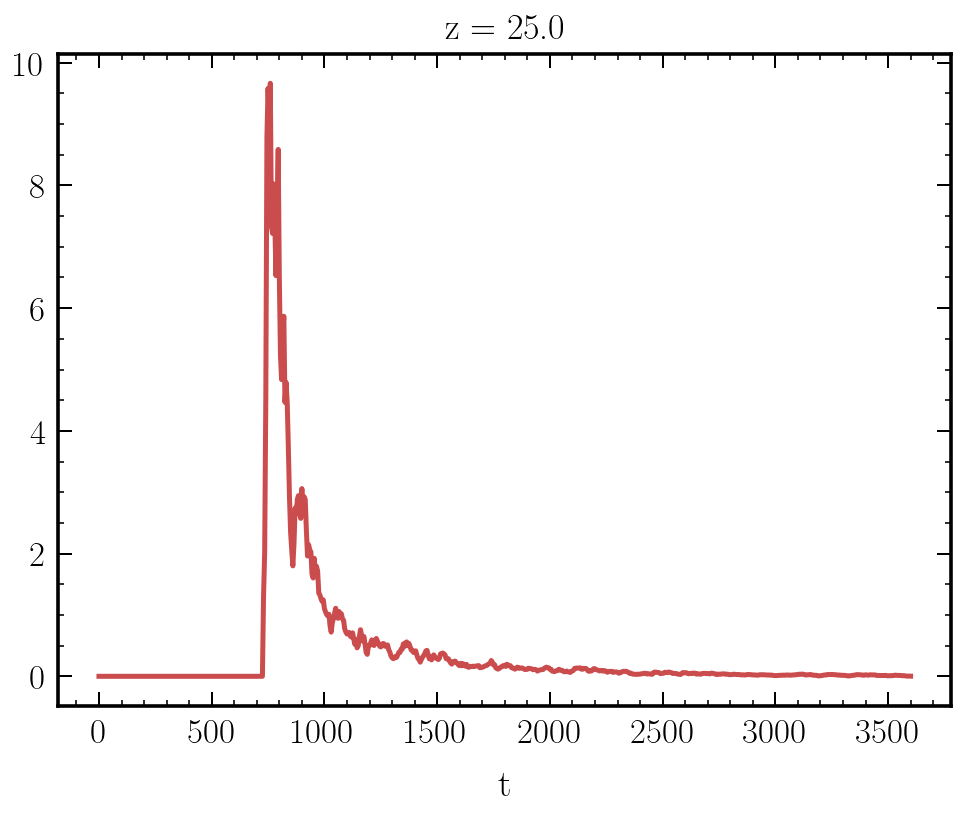

In [6]:
fig, ax= plt.subplots(1, 1, figsize=(8, 6))
surface_rain.mean(dim= "run").sel(z= 25).plot(ax= ax)
surface_rain.mean(dim= "run").sel(z= 25).sum()

In [15]:
(960 * 120)/3600

32.0

## Plotting

### Heatmap plot

In [34]:
kid_run_df= pd.read_hdf(sav_file_path + 'KiD_run_rhow=2.0_rbkg_0.1_rseed_1_zseed_0.25_summary.h5', key='df')
prec_df= kid_run_df[kid_run_df.norm_seed == 1]['surf_precip_mean']
prec_df= prec_df.loc[prec_df.index.repeat(10)].reset_index(drop= True) # repeat each row 10 times
kid_run_df['surf_precip_mean']= kid_run_df['surf_precip_mean'] - prec_df
kid_run_df['snr']= kid_run_df['surf_precip_mean']/kid_run_df['surf_precip_std']
kid_run_df['excess_precip']= kid_run_df['surf_precip_mean'] - kid_run_df['surf_precip_std']
kid_run_df= kid_run_df.dropna()

In [35]:
# Pivot the DataFrame to reshape it into a format suitable for heatmap
heatmap_data = kid_run_df.pivot_table(index='norm_seed', columns='norm_bkg', values='excess_precip')

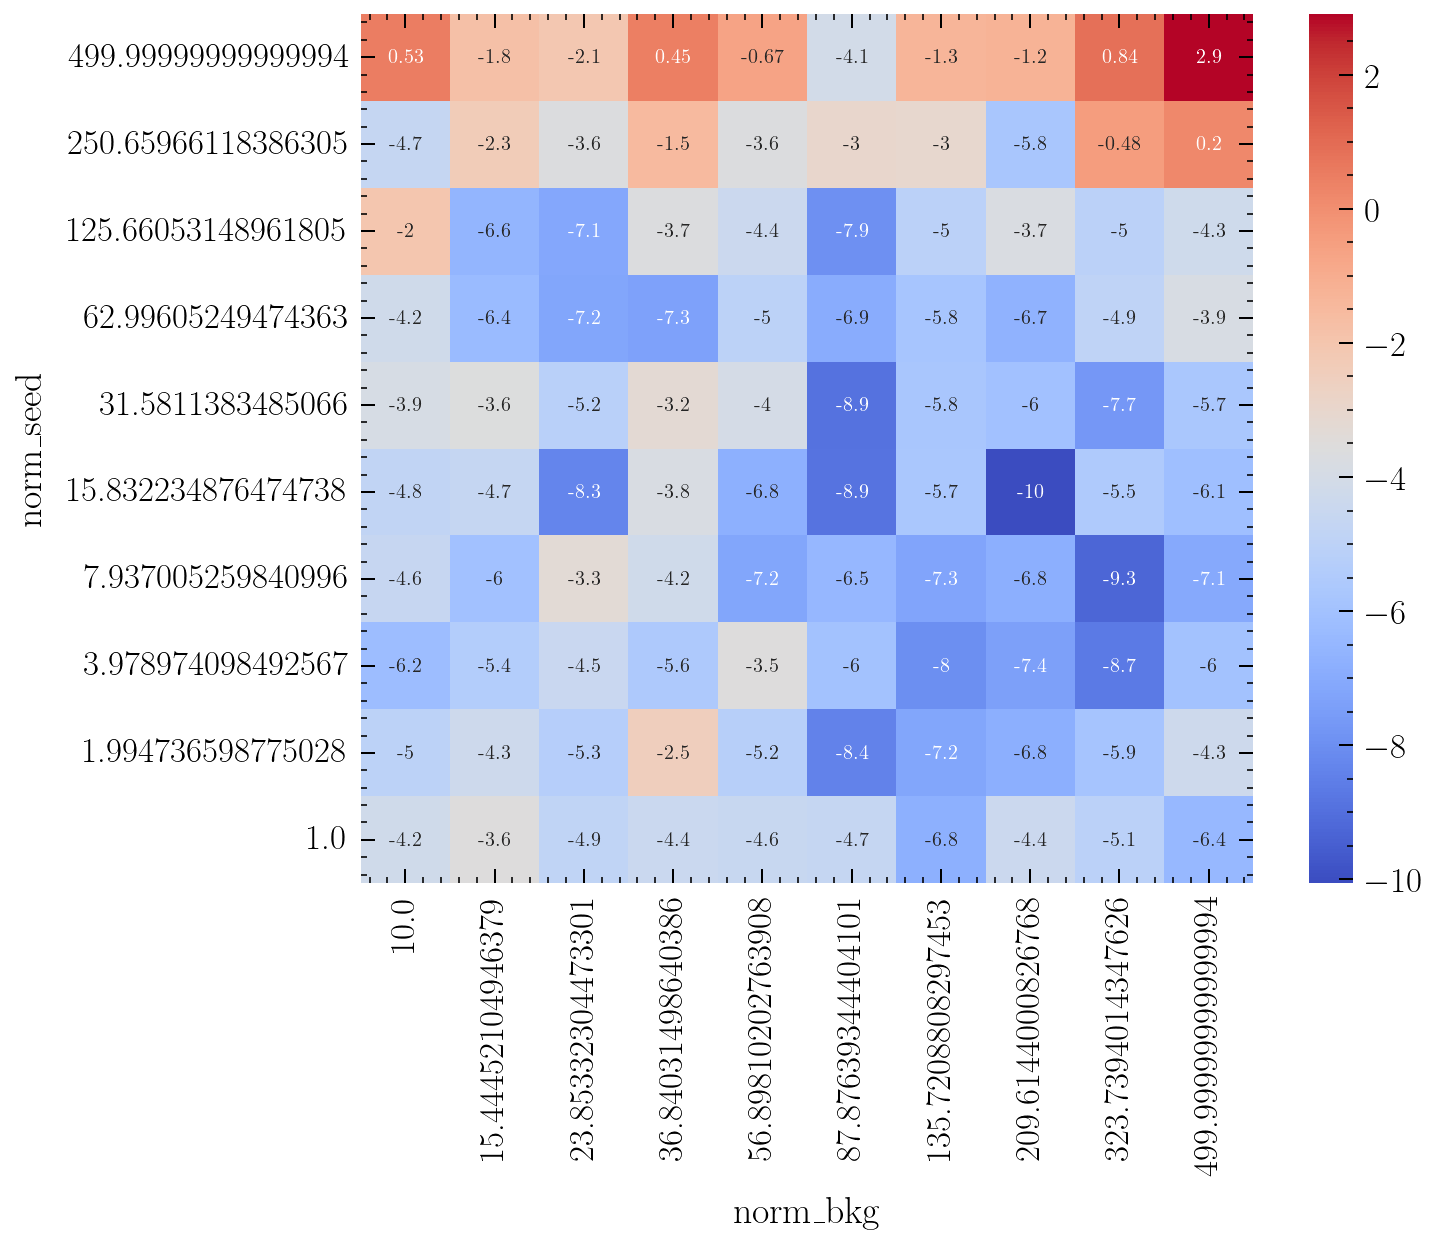

In [36]:
# Create the heatmap
plt.figure(figsize=(10, 8))
ax= sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
ax.invert_yaxis()

In [37]:
kid_run_df= kid_run_df[kid_run_df.norm_bkg > 50].reset_index(drop= True)

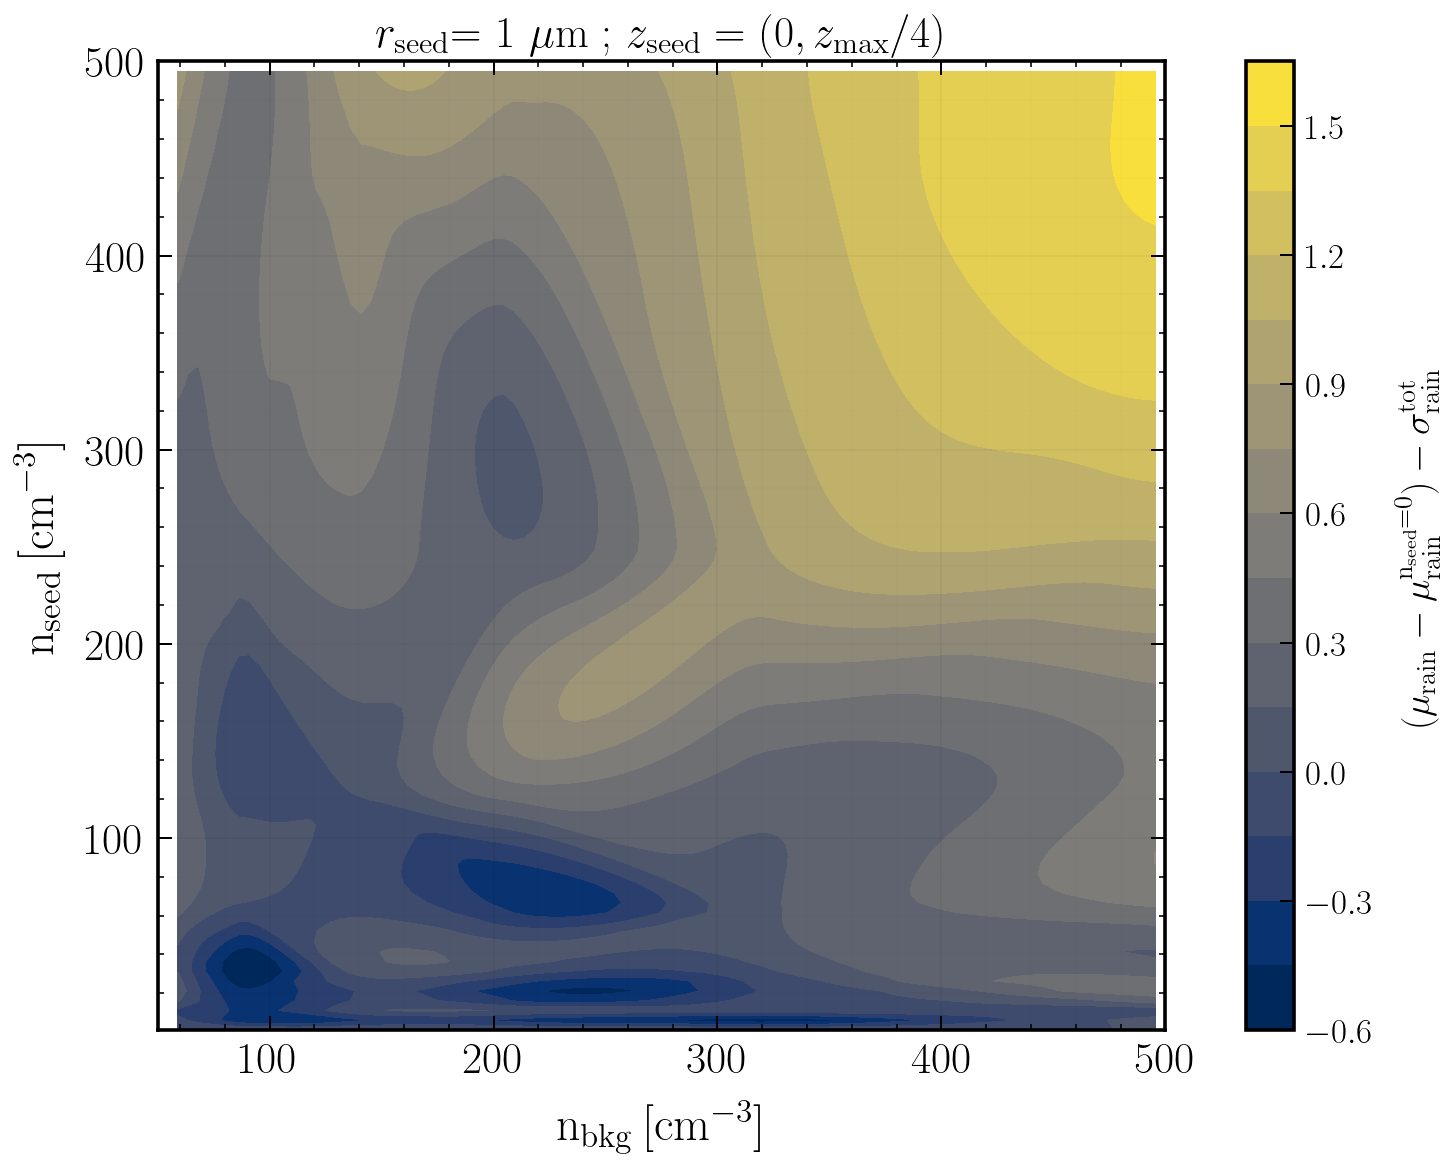

In [38]:
# Define the grid for interpolation
grid_x, grid_y = np.mgrid[50:500:100j, 1:500:100j]

# Interpolate the z values to the grid
grid_z = griddata((kid_run_df['norm_bkg'], kid_run_df['norm_seed']), kid_run_df['snr'], (grid_x, grid_y), method='cubic')

# Create the contour plot
fig, ax= plt.subplots(1, 1, figsize= (10, 8) , constrained_layout= True)
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap='cividis')
ax.set_xlabel(r'${\rm n}_{\rm bkg} \, [{\rm cm}^{-3}]$', fontsize= 24)
ax.set_ylabel(r'${\rm n}_{\rm seed} \, [{\rm cm}^{-3}]$', fontsize= 24)
#plt.yscale('log')
#plt.xscale('log')

# Add a colorbar
#fig.colorbar(contour, label= r'$(\mu_{\rm rain} - \mu^{{\rm n}_{\rm seed} = 0}_{\rm rain})/\sigma_{\rm rain}$')
fig.colorbar(contour, label= r'$(\mu_{\rm rain} - \mu^{{\rm n}_{\rm seed} = 0}_{\rm rain}) - \sigma^{\rm tot}_{\rm rain}$')

ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');

ax.set_title(r'$r_{\rm seed}$= 1 $\mu {\rm m}$ ; $z_{\rm seed} = (0, z_{\rm max}/4)$', fontsize= 22); 
plt.savefig(sav_plt_path + 'bkg_seed_conc_rseed_1_zseed_0.25_excess_precip.pdf', bbox_inches='tight', dpi= 300);

### Trajectory plot

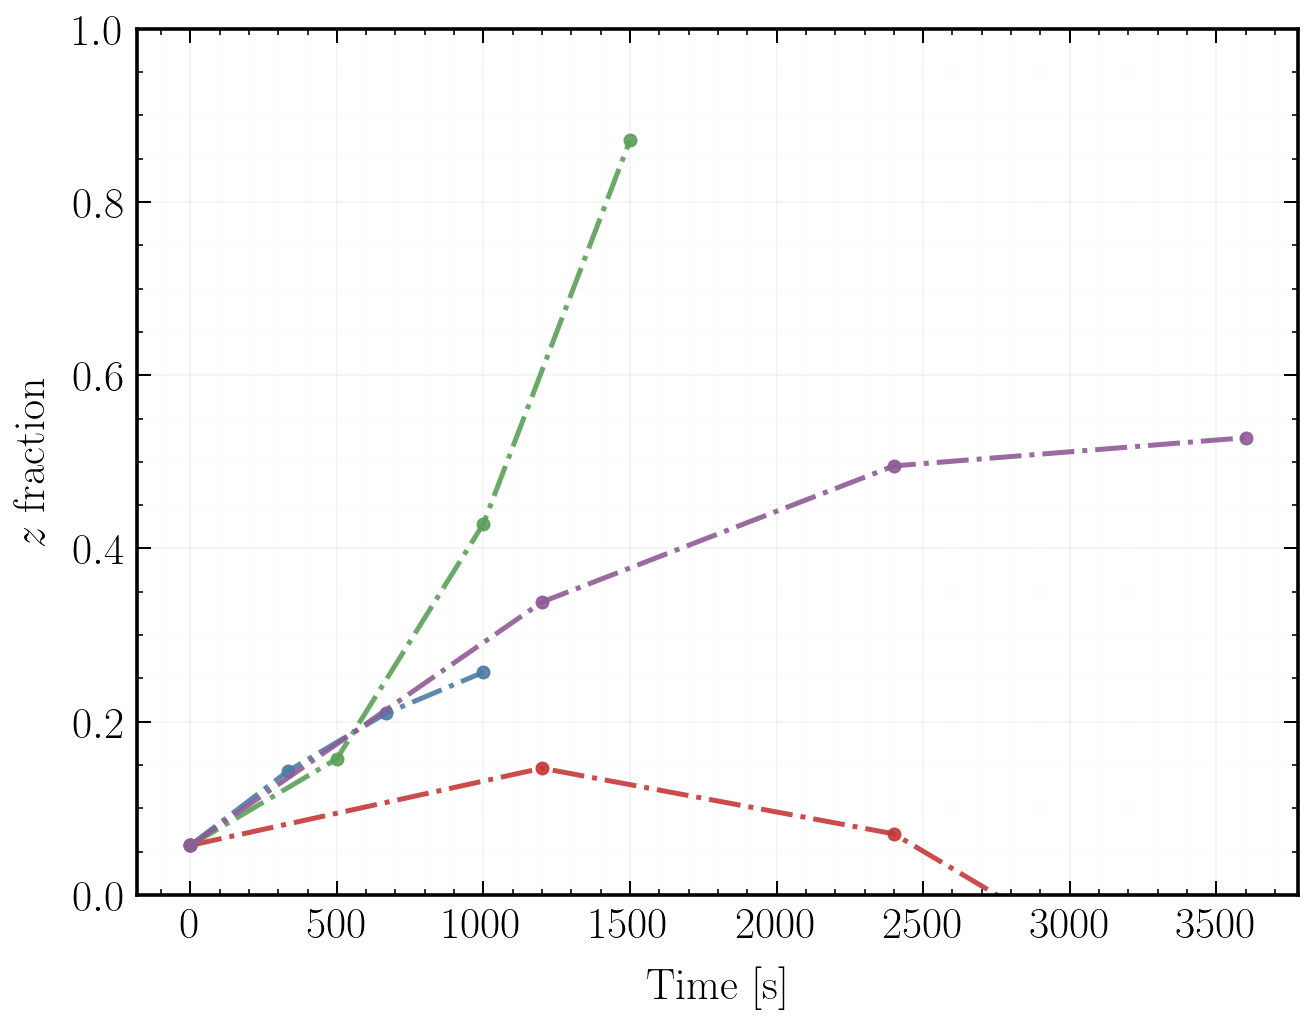

In [58]:
# Prepare plot
fig, ax= plt.subplots(1, 1, figsize= (9, 7) , constrained_layout= True)

time_points = np.linspace(0, 3600, 4)  # Four equally spaced time points: [0, 1200, 2400, 3600]
time_points_1000 = np.linspace(0, 1000, 4)  # Four equally spaced time points: [0, 333, 667, 1000]
time_points_1500 = np.linspace(0, 1500, 4)  # Four equally spaced time points: [0, 500, 1000, 1500]

non_monotonic_coefficients = [
    {'v0': 0.5, 'a1': -0.0002, 'a2': -1e-10},
    {'v0': 1., 'a1': -0.0003, 'a2': -2e-10},
    {'v0': 0.1, 'a1': 0.0012, 'a2': -1.2e-10},
    {'v0': 1.0, 'a1': -0.00015, 'a2': -1.8e-10}
]
z0 = 200

# Plot each configuration with z scaled to [0, 1]
for idx, coeff in enumerate(non_monotonic_coefficients):
    # Unpack coefficients
    v0_cubic = coeff['v0']
    a1_cubic = coeff['a1']
    a2_cubic = coeff['a2']

    # Use different end times for some of the configurations
    if idx % 3 == 0:  # First and fourth curves use the full 3600s range
        time_points_to_use = time_points
    elif idx % 3 == 1:  # Second curve ends at 1000s
        time_points_to_use = time_points_1000
    else:  # Third curve ends at 1500s
        time_points_to_use = time_points_1500
    
    # Calculate z(t) for the current configuration
    z_cubic_original = z0 + v0_cubic * time_points_to_use + a1_cubic * time_points_to_use**2 + a2_cubic * time_points_to_use**3
    
    # Normalize z(t) to the range [0, 1]
    z_cubic_scaled = z_cubic_original / 3500  # Normalize by the max value of 3500
    
    # Plot
    plt.plot(time_points_to_use, z_cubic_scaled, label=f"v0={v0_cubic}, a1={a1_cubic}, a2={a2_cubic}", marker='o', linestyle='-.')

# Add labels and grid
plt.xlabel("Time [s]", fontsize= 22)
plt.ylabel(r"$z$ fraction", fontsize= 22)
plt.ylim(0, 1)  # Ensure z is between 0 and 1
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');